In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
df = pd.read_csv('cisplatin.csv')
df

,Unnamed: 0,drug,cell_line,log10_dose,viability
0,1,CISPLATIN,924238,-2.397711,0.972837
1,2,CISPLATIN,924238,-2.221620,1.000000
2,3,CISPLATIN,924238,-1.897749,0.947334
3,4,CISPLATIN,924238,-1.721658,1.000000
4,5,CISPLATIN,924238,-1.408240,0.931629
...,...,...,...,...,...
19509,19510,CISPLATIN,908441,-0.221772,0.923064
19510,19511,CISPLATIN,908441,0.102098,1.000000
19511,19512,CISPLATIN,908441,0.278189,0.622700
19512,19513,CISPLATIN,908441,0.602060,0.847234


In [3]:
def preprocess_data(df, cell_line_indices):
    df_copy = df[['cell_line', 'log10_dose', 'viability']]
    
    unique_cell_lines = df_copy['cell_line'].unique()
    selected_cell_lines = unique_cell_lines[cell_line_indices]  # Select by indices
    
    df_subset = df_copy[df_copy['cell_line'].isin(selected_cell_lines)]
    
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')
    
    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)
    
    return x, Y.T

list_cell_lines = [3, 13, 15, 29, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
x, Y = preprocess_data(df, list_cell_lines)

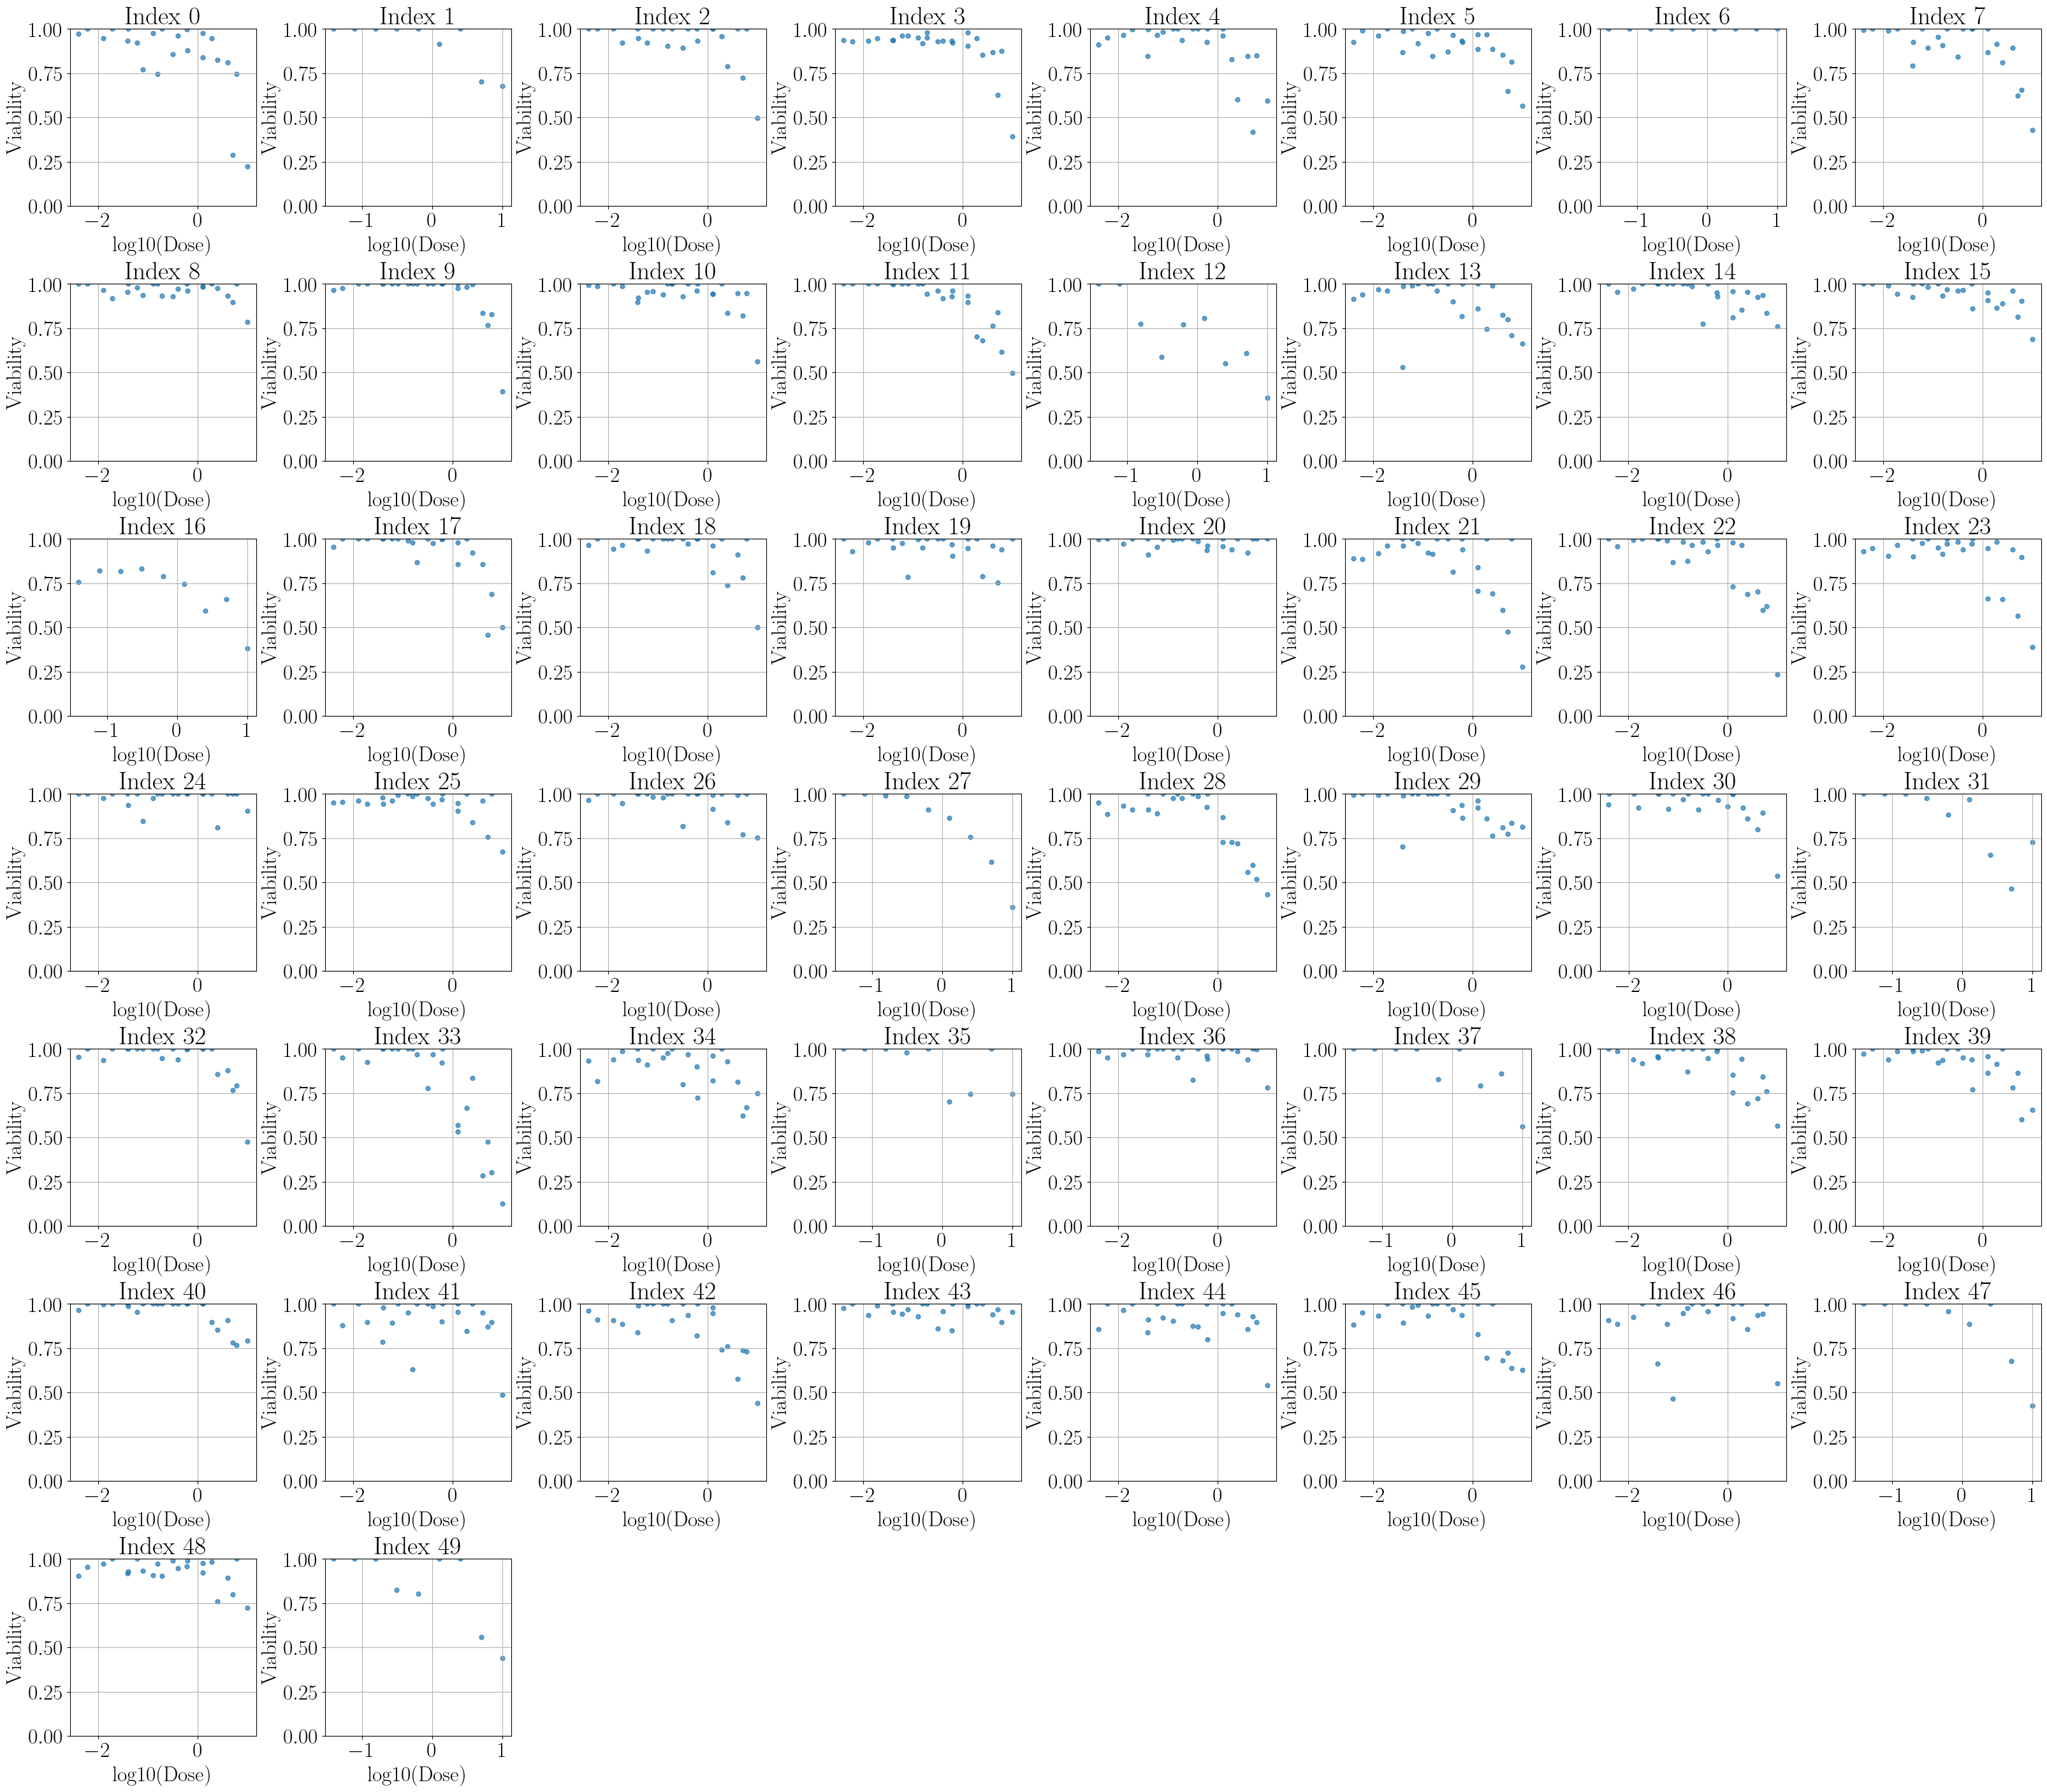

In [10]:
def visual_examples(df, k):
    unique_cell_lines = df['cell_line'].unique()
    k = min(k, len(unique_cell_lines))  # avoid indexing error

    # Calculate number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[i]
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)
        ax.set_title(f'Index {i}')
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)

        ax.set_ylim(0, 1)

    # Hide any unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

visual_examples(df, 50)

In [4]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

A:
 [[1.04967142 0.98617357 1.06476885 1.15230299 0.97658466]
 [0.9765863  1.15792128 1.07674347 0.95305256 1.054256  ]
 [0.95365823 0.95342702 1.02419623 0.80867198 0.82750822]
 [0.94377125 0.89871689 1.03142473 0.90919759 0.85876963]
 [1.14656488 0.97742237 1.00675282 0.85752518 0.94556173]
 [1.01109226 0.88490064 1.0375698  0.93993613 0.97083063]
 [0.93982934 1.18522782 0.99865028 0.89422891 1.08225449]
 [0.87791564 1.02088636 0.80403299 0.8671814  1.01968612]
 [1.07384666 1.01713683 0.98843517 0.96988963 0.8521478 ]
 [0.92801558 0.95393612 1.10571222 1.03436183 0.82369598]
 [1.0324084  0.96149177 0.9323078  1.06116763 1.10309995]
 [1.09312801 0.91607825 0.96907876 1.03312634 1.09755451]
 [0.95208258 0.9814341  0.8893665  0.88037934 1.08125258]
 [1.135624   0.99279899 1.10035329 1.0361636  0.93548802]
 [1.03613956 1.15380366 0.9964174  1.15646437 0.73802549]
 [1.08219025 1.00870471 0.97009926 1.00917608 0.80124311]]
B:
 [[5.48960088 5.44126456 4.77177152 4.86150182 5.15093344 5.0699

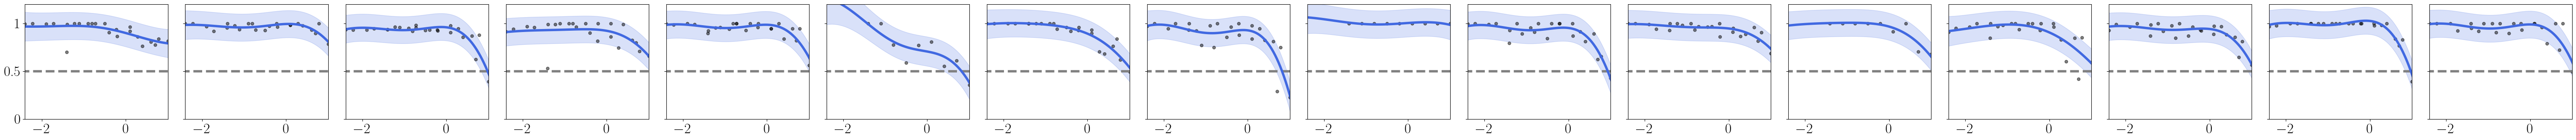

In [5]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = 0.1
init_A = generate_A(d=n_outputs, r=5, noise_level=0.1, seed=42)
print("A:\n", init_A)
print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(n_outputs = n_outputs, mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
mogp.fit(x, Y)
print(len(x))
# Optimize hyperparameters
mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

When trained on 16 output functions (~1min20sec)

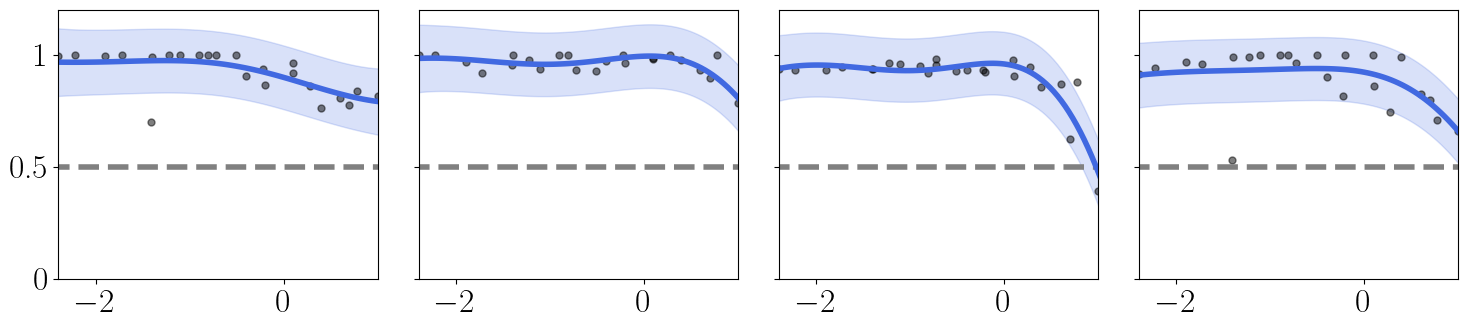

In [7]:
# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # Dynamically adjust figure size

for i in range(4):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()